# CIFAR10 Transfer Learning based Classifier

This notebook outlines the steps to build a classifier to leverage concepts of Transfer Learning by utilizing a pretrained Deep-CNN. 
Particularly in this case based on VGG16

In [1]:
pip install cnn_utils

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cnn_utils (from versions: none)
ERROR: No matching distribution found for cnn_utils


In [2]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Pandas and Numpy for data structures and util fucntions
import scipy as sp
import numpy as np
import pandas as pd
from numpy.random import rand
pd.options.display.max_colwidth = 600

# Scikit Imports
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.model_selection import train_test_split

import cnn_utils as utils
from model_evaluation_utils import get_metrics

# Matplot Imports
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'}

plt.rcParams.update(params)
%matplotlib inline

# pandas display data frames as tables
from IPython.display import display, HTML

import warnings
warnings.filterwarnings('ignore')

In [4]:
import keras
#from keras.utils import np_utils

In [5]:
import tensorflow as tf
from keras import callbacks
from keras import optimizers
from keras.datasets import cifar10
from tensorflow.keras.models import Model
from keras.applications import vgg16 as vgg
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
#from keras.utils import np_utils

In [6]:
pip install np_utils

In [7]:
import np_utils

## Load and Prepare DataSet

In [8]:
BATCH_SIZE = 32
EPOCHS = 25
NUM_CLASSES = 10
LEARNING_RATE = 1e-4
MOMENTUM = 0.9

In [9]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

Split training dataset in train and validation sets

In [10]:
X_train, X_val, y_train, y_val = train_test_split(X_train, 
                                                  y_train, 
                                                  test_size=0.15, 
                                                  stratify=np.array(y_train), 
                                                  random_state=42)

In [11]:
print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(42500, 1)
(7500, 1)
(10000, 1)


Transform target variable/labels into one hot encoded form

In [12]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

In [13]:
from keras.utils import to_categorical

In [14]:
Y_train = to_categorical(y_train, NUM_CLASSES)
Y_val = to_categorical(y_val, NUM_CLASSES)
Y_test = to_categorical(y_test, NUM_CLASSES)

### Preprocessing

Since we are about to use VGG16 as a feature extractor, the minimum size of an image it takes is 48x48.
We utilize ```scipy`` to resize images to required dimensions

In [15]:
from skimage import transform
X_train = np.array([transform.resize(x, 
                                     (48, 48)) for x in X_train])
X_val = np.array([transform.resize(x, 
                                   (48, 48)) for x in X_val])
X_test = np.array([transform.resize(x, 
                                    (48, 48)) for x in X_test])

## Prepare the Model

* Load VGG16 without the top classification layer
* Prepare a custom classifier
* Stack both models on top of each other

In [16]:
base_model = vgg.VGG16(weights='imagenet', 
                       include_top=False, 
                       input_shape=(48, 48, 3))

In [17]:
# Extract the last layer from third block of vgg16 model
last = base_model.get_layer('block3_pool').output

In [18]:
# Add classification layers on top of it
x = GlobalAveragePooling2D()(last)
x= BatchNormalization()(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.6)(x)
pred = Dense(NUM_CLASSES, activation='softmax')(x)
model = Model(base_model.input, pred)

Since our objective is to only train the custom classifier, we freeze the layers of VGG16

In [19]:
for layer in base_model.layers:
     layer.trainable = False

In [20]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

## Data Augmentation

To help model generalize and overcome the limitations of a small dataset, we prepare augmented datasets using 
```keras ``` utilities

In [22]:
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=False)

In [23]:
train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train,
                                     Y_train, 
                                     batch_size=BATCH_SIZE)

In [24]:
val_datagen = ImageDataGenerator(rescale=1. / 255,
    horizontal_flip=False)

val_datagen.fit(X_val)
val_generator = val_datagen.flow(X_val,
                                 Y_val,
                                 batch_size=BATCH_SIZE)

## Train the Model

In [25]:
train_steps_per_epoch = X_train.shape[0] // BATCH_SIZE
val_steps_per_epoch = X_val.shape[0] // BATCH_SIZE

history = model.fit_generator(train_generator,
                              steps_per_epoch=train_steps_per_epoch,
                              validation_data=val_generator,
                              validation_steps=val_steps_per_epoch,
                              epochs=EPOCHS,
                              verbose=1)

Epoch 1/25


1328/1328 [==============================] - 339s 242ms/step - loss: 0.3146 - accuracy: 0.2828 - val_loss: 0.2426 - val_accuracy: 0.4527
Epoch 2/25
1328/1328 [==============================] - 321s 242ms/step - loss: 0.2499 - accuracy: 0.4256 - val_loss: 0.2198 - val_accuracy: 0.5104
Epoch 3/25
1328/1328 [==============================] - 321s 242ms/step - loss: 0.2310 - accuracy: 0.4815 - val_loss: 0.2077 - val_accuracy: 0.5437
Epoch 4/25
1328/1328 [==============================] - 377s 284ms/step - loss: 0.2196 - accuracy: 0.5100 - val_loss: 0.2000 - val_accuracy: 0.5609
Epoch 5/25
1328/1328 [==============================] - 414s 311ms/step - loss: 0.2124 - accuracy: 0.5296 - val_loss: 0.1940 - val_accuracy: 0.5721
Epoch 6/25
1328/1328 [==============================] - 347s 262ms/step - loss: 0.2066 - accuracy: 0.5450 - val_loss: 0.1895 - val_accuracy: 0.5811
Epoch 7/25
1328/1328 [==============================] - 345s 260ms/step - loss: 0.2011 - accuracy: 0.5584 - va

## Analyze Model Performance

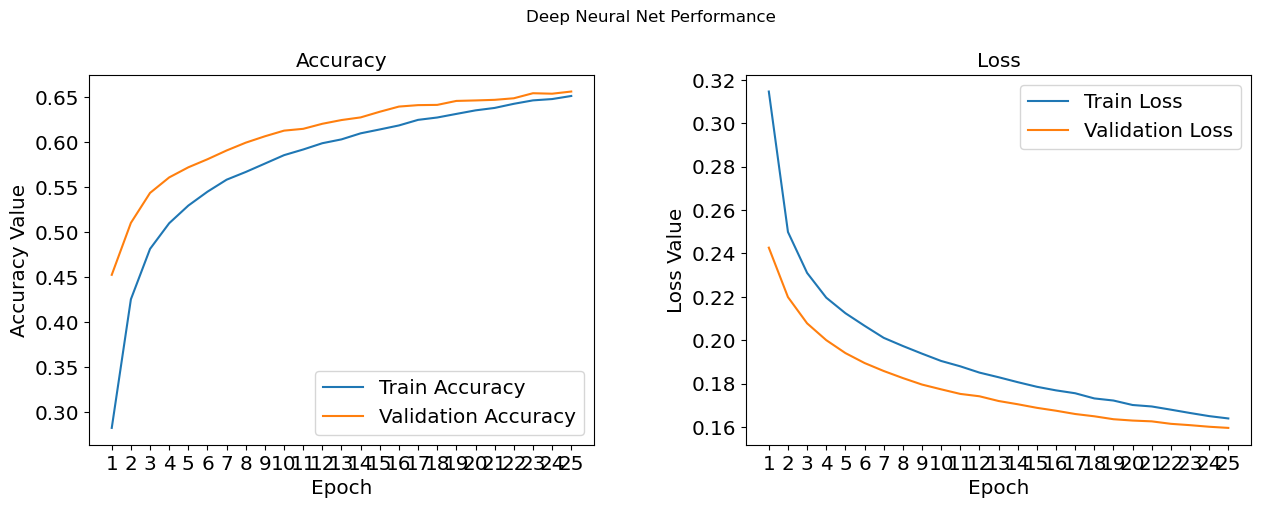

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('Deep Neural Net Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,EPOCHS+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [27]:
predictions = model.predict(X_test/255.)

313/313 [==============================] - 83s 261ms/step


In [28]:
test_labels = list(y_test.squeeze())
predictions = list(predictions.argmax(axis=1))

In [29]:
get_metrics(true_labels=y_test, 
                predicted_labels=predictions)

Accuracy: 0.6561
Precision: 0.6539
Recall: 0.6561
F1 Score: 0.6535


## Visualize Predictions

In [30]:
classes = ['airplane', 'automobile', 'bird',
             'cat',
            'deer',
             'dog',
             'frog',
             'horse',
             'ship',
             'truck']

In [31]:
base_model = vgg.VGG16(weights='imagenet',
                      include_top=False,
                      input_shape=(48, 48, 3))

In [6]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([]) 
    plt.imshow(img, cmap=plt.cm.binary)
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
        plt.xlabel("{} {:2.0f}% ({})".format(label_dict[predicted_label],
                                            100 * np.max(predictions_array),
                                            label_dict[true_label]),
                                            color=color)
        
        R = 5
        C = 5
        fig, axes = plt.subplots(R,C, figsize=(12,12))
        axes = axes.ravel()
        
        for i in np.arrange(0, R*C):
            axes[i].imshow(X_test[i])
            axes[i].set_titles("True: %s \n Predict: %s" % (classes[np.argmax(Y_test[i])],
                                                           classes[predictions[i]]))
            axes[i].axis('off')
            plt.subplots_adjust(wepace=1)

In [25]:
'VGG_16'

Accuracy: 0.6561
Precision: 0.6539
Recall: 0.6561
F1_Score: 0.6535

In [26]:
'RestNet50'

Accuracy: 0.5369
Precision: 0.5562
Recall: 0.5369
F1_Score: 0.529

In [27]:
'MobileNet'

Accuracy: 0.558
Precision: 0.5557
Recall: 0.558
F1_Score: 0.5542

In [28]:
'ResNet152V2'

Accuracy: 0.512
Precision: 0.52
Recall: 0.512
F1_Score: 0.5076

In [29]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

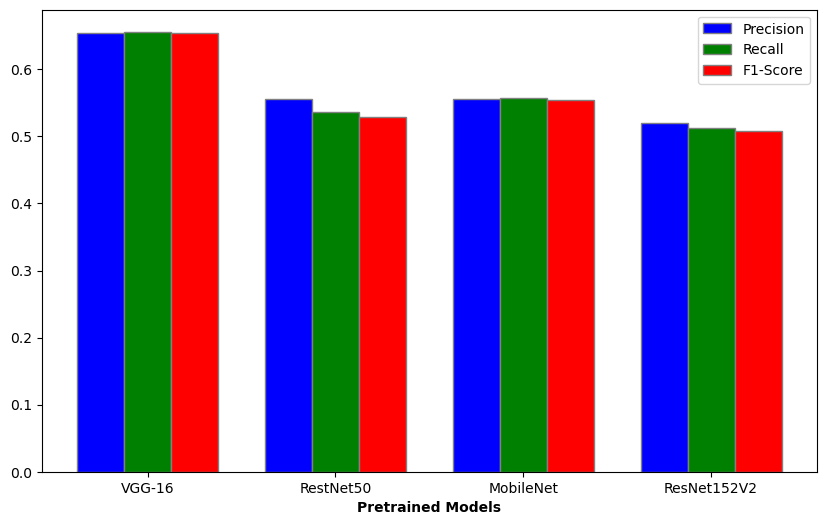

In [9]:
import matplotlib.pyplot as plt
import pandas as pd

# Data
PretrainedModels = ['VGG-16', 'RestNet50', 'MobileNet', 'ResNet152V2']
Precision = [0.6539, 0.5562, 0.5557, 0.52]
Recall = [0.6561, 0.5369, 0.558, 0.512]
F1_Score = [0.6535, 0.529, 0.5542, 0.5076]

# Create DataFrame
data = {
    'PretrainedModels': PretrainedModels,
    'Precision': Precision,
    'Recall': Recall,
    'F1_Score': F1_Score
}

df = pd.DataFrame(data)

# Plot
fig, ax = plt.subplots(figsize=(10, 6))

# Width of the bars
bar_width = 0.25

# Set position of bar on X axis
r1 = range(len(df))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Make the plot
plt.bar(r1, df['Precision'], color='b', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r2, df['Recall'], color='g', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r3, df['F1_Score'], color='r', width=bar_width, edgecolor='grey', label='F1-Score')

# Add xticks on the middle of the group bars
plt.xlabel('Pretrained Models', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(df))], df['PretrainedModels'])

# Create legend & Show graphic
plt.legend()
plt.show()
